# Data loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pickle

os.chdir("/content/drive/MyDrive/Reconocimiento de Patrones")

with open('preprocessed_data.pickle', 'rb') as file:
    filt_dict = pickle.load(file)
    segm_dict = pickle.load(file)
    norm_segm_dict = pickle.load(file)

Mounted at /content/drive


# Segmentación | Extracción de media y desviación estándar

In [2]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Calcula la longitud de todas las secuencias
lengths = [len(seq) for seq in norm_segm_dict['ABP']]  # Asumiendo ABP como referencia; también puedes combinar las longitudes de CBFV y ICP si es necesario

# Usa el percentil 95 para determinar max_len
max_len = int(np.percentile(lengths, 95))

print("Longitud de padding seleccionada:", max_len)

# Asumiendo que has calculado max_len como se indicó antes
norm_segm_dict['ABP'] = pad_sequences(norm_segm_dict['ABP'], maxlen=max_len, dtype='float32', padding='post', truncating='post')
norm_segm_dict['CBFV'] = pad_sequences(norm_segm_dict['CBFV'], maxlen=max_len, dtype='float32', padding='post', truncating='post')
norm_segm_dict['ICP'] = pad_sequences(norm_segm_dict['ICP'], maxlen=max_len, dtype='float32', padding='post', truncating='post')

Longitud de padding seleccionada: 122


In [3]:
# Calcular media
cbfv_means = np.array([np.mean(seq) for seq in segm_dict['CBFV']])
abp_means = np.array([np.mean(seq) for seq in segm_dict['ABP']])
icp_means = np.array([np.mean(seq) for seq in segm_dict['ICP']])

# Calcular std
cbfv_std = np.array([np.std(seq) for seq in segm_dict['CBFV']])
abp_std = np.array([np.std(seq) for seq in segm_dict['ABP']])
icp_std = np.array([np.std(seq) for seq in segm_dict['ICP']])

# Crear la matriz de características combinando medias y desviaciones estándar de ABP y CBFV
X_2 = np.column_stack((abp_means, abp_std, cbfv_means, cbfv_std))

# Crear la matriz de etiquetas con medias y desviaciones estándar de ICP
y_2 = np.column_stack((icp_means, icp_std))

# LSTM for ICP waveform

In [4]:
from sklearn.model_selection import train_test_split

X = np.stack((norm_segm_dict['ABP'], norm_segm_dict['CBFV']), axis=-1)  # Forma: [num_samples, timesteps, num_channels]
y = norm_segm_dict['ICP']

y_or = segm_dict['ICP']

original_lengths = np.array([len(seq) for seq in y_or])

# Crear un arreglo de índices
indices = np.arange(len(X))

# Primero dividir en entrenamiento y prueba
indices_train, indices_test = train_test_split(indices, test_size=0.1, random_state=110)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
indices_train, indices_val = train_test_split(indices_train, test_size=0.2, random_state=110)  # 0.25 x 0.8 = 0.2

# Usar estos índices para dividir tus datos originales y estadísticos
X_train, X_val, X_test = X[indices_train], X[indices_val], X[indices_test]
y_train, y_val, y_test = y[indices_train], y[indices_val], y[indices_test]

X_train2, X_val2, X_test2 = X_2[indices_train], X_2[indices_val], X_2[indices_test]
y_train2, y_val2, y_test2 = y_2[indices_train], y_2[indices_val], y_2[indices_test]

train_lengths, val_lengths, test_lengths = original_lengths[indices_train], original_lengths[indices_val], original_lengths[indices_test]

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
from keras.callbacks import ReduceLROnPlateau
from keras.losses import Huber
# from keras.optimizers import Adam

# Definir el modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(max_len, 2)))
model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(TimeDistributed(Dense(1)))

model_lstm.compile(optimizer='adam', loss=Huber(delta=1.0))

# Entrenamiento del modelo
history_lstm = model_lstm.fit(X_train, y_train, epochs=70, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/70
597/597 [==============================] - 17s 18ms/step - loss: 0.1145 - val_loss: 0.0920
Epoch 2/70
597/597 [==============================] - 8s 13ms/step - loss: 0.0865 - val_loss: 0.0770
Epoch 3/70
597/597 [==============================] - 9s 15ms/step - loss: 0.0758 - val_loss: 0.0722
Epoch 4/70
597/597 [==============================] - 10s 16ms/step - loss: 0.0698 - val_loss: 0.0659
Epoch 5/70
597/597 [==============================] - 9s 14ms/step - loss: 0.0646 - val_loss: 0.0629
Epoch 6/70
597/597 [==============================] - 9s 15ms/step - loss: 0.0614 - val_loss: 0.0623
Epoch 7/70
597/597 [==============================] - 8s 14ms/step - loss: 0.0590 - val_loss: 0.0552
Epoch 8/70
597/597 [==============================] - 9s 14ms/step - loss: 0.0570 - val_loss: 0.0547
Epoch 9/70
597/597 [==============================] - 9s 15ms/step - loss: 0.0557 - val_loss: 0.0555
Epoch 10/70
597/597 [==============================] - 8s 13ms/step - loss: 0.0543 - val_

# Overfitting check before saving


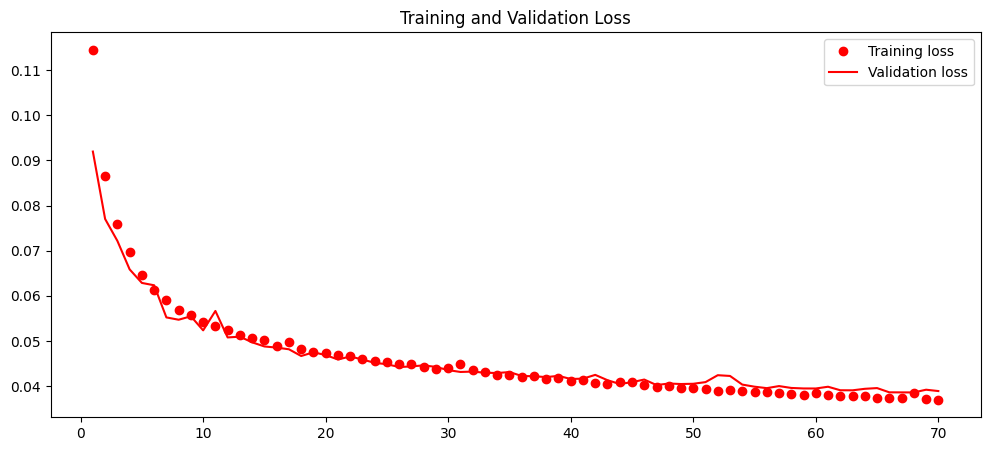

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, 70 + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history_lstm)

In [8]:
model_lstm.save('ModelosLSTM/model1a.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Pruebas Waveform

166/166 [==============================] - 2s 6ms/step


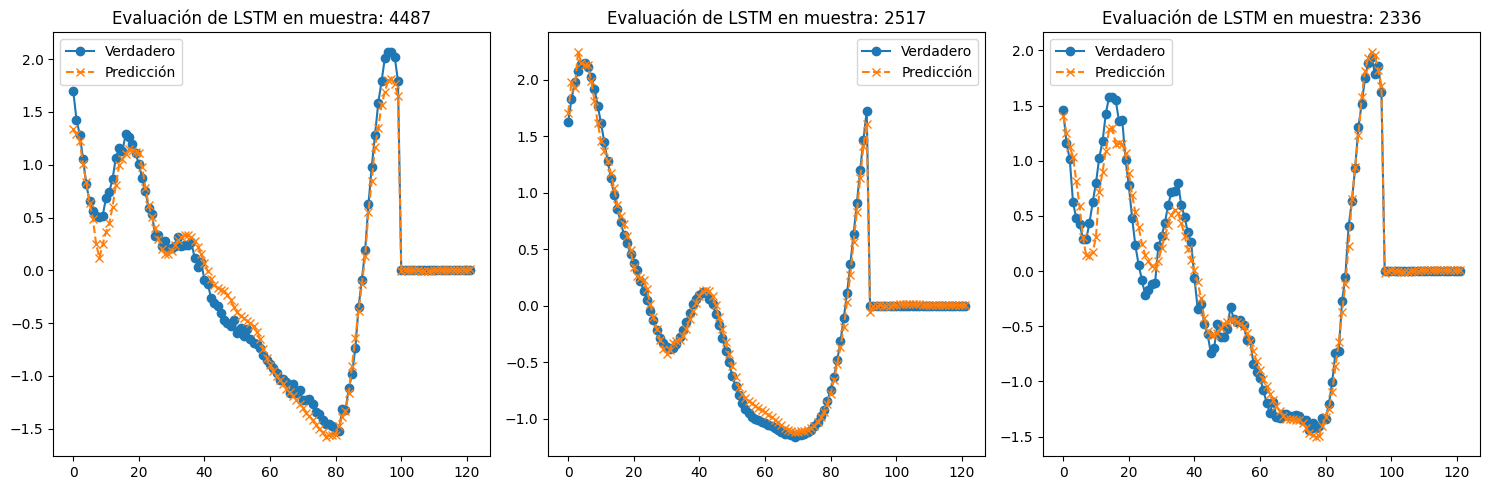

y_test shape: (5299, 122)
predictions shape: (5299, 122, 1)


In [9]:
import numpy as np

# Obtener las predicciones del modelo
predictions = model_lstm.predict(X_test)
predictions_trimmed = [pred[:length] for pred, length in zip(predictions, test_lengths)]
y_test_trimmed = [pred[:length] for pred, length in zip(y_test, test_lengths)]

# Seleccionar 20 índices aleatorios para mostrar
num_examples = 3
indices = np.random.choice(len(predictions_trimmed), num_examples, replace=False)
indices = [4486, 2516, 2335]

# Configurar la figura para mostrar múltiples subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # Ajusta el tamaño de la figura según necesidad
axes = axes.flatten()  # Aplanar el array de axes para una iteración más fácil

for idx, ax in zip(indices, axes):
    ax.plot(y_test[idx], label='Verdadero', marker='o', linestyle='-')
    ax.plot(predictions[idx], label='Predicción', marker='x', linestyle='--')
    ax.set_title(f'Evaluación de LSTM en muestra: {idx+1}')
    ax.legend()

# Ajustar el layout para evitar la superposición de subplots
plt.tight_layout()
plt.show()

# Imprimir las dimensiones para referencia
print("y_test shape:", y_test.shape)
print("predictions shape:", predictions.shape)

# Modelo para Media y Desviación estándar

In [10]:
from keras.models import Sequential
from keras.layers import Dense

def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(2)  # Salida: media y desviación estándar de ICP
    ])
    model.compile(optimizer='adam', loss='mse')  # Usar el error cuadrático medio como función de pérdida
    return model

# Supongamos que cada muestra de entrada tiene 4 características: media y std de ABP, media y std de CBFV
model = build_model(input_dim=4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4610 (18.01 KB)
Trainable params: 4610 (18.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train2, y_train2, epochs=100, batch_size=32, validation_data=(X_test2, y_test2))

# Overfitting check before saving


In [ ]:
plot_training_history(history)

In [ ]:
model.save('ModelosMEANSTD/model2a.h5')

# Pruebas Media y Desviación estándar

In [ ]:
import matplotlib.pyplot as plt

predictions = model.predict(X_test2)
plt.figure(figsize=(10, 5))
plt.scatter(y_test2[:, 0], predictions[:, 0], alpha=0.5, label='Media ICP')
plt.scatter(y_test2[:, 1], predictions[:, 1], alpha=0.5, label='Desviación estándar ICP')
plt.xlabel('Valores verdaderos')
plt.ylabel('Predicciones')
plt.title('Comparación de los valores verdaderos vs predicciones')
plt.legend()
plt.show()

In [ ]:
# Calcular medias y diferencias
means = 0.5 * (y_test2[:, 0] + predictions[:, 0])
diffs = y_test2[:, 0] - predictions[:, 0]

# Valores para las líneas
mean_diff = np.mean(diffs)
std_diff = np.std(diffs)
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff
print(std_diff)
# Plot Bland-Altman
plt.figure(figsize=(10, 5))
plt.scatter(means, diffs, alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean: {mean_diff:.2f}')
plt.axhline(upper_limit, color='red', linestyle=':', label=f'+1.96 SD: {upper_limit:.2f}')
plt.axhline(lower_limit, color='red', linestyle=':', label=f'-1.96 SD: {lower_limit:.2f}')

plt.title('Bland-Altman Plot')
plt.xlabel('Means')
plt.ylabel('Differences')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(y_test2[:, 0], predictions[:, 0])
mse = mean_squared_error(y_test2[:, 0], predictions[:, 0])
r2 = r2_score(y_test2[:, 0], predictions[:, 0])

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")